# FGSM attack on MNIST/ImageNet
Author: Xuechao Zhang  
Date: May 17th, 2022  
Description: FGSM(Fast Gradient Sign Attack) attack,
            a white-box attack with the goal of misclassification.  
Reference: https://pytorch.org/tutorials/beginner/fgsm_tutorial.html

## Start

In [37]:
from __future__ import print_function
import sys
import os
os.chdir(sys.path[0])  # 当前文件目录
# sys.path.insert(0, os.path.split(__file__)[0])
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# NOTE: This is a hack to get around "User-agent" limitations when downloading MNIST datasets
#       see, https://github.com/pytorch/vision/issues/3497 for more information
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

## Inputs
选择数据集和预训练的模型:  
MNIST (LeNet) or ImageNet (MobileNet V2)

In [38]:
# 进行测试的epsilon值; 0表示未进行攻击时的检测结果; 注意原始数据范围[0,1]
epsilons = [0, .05, .1, .15, .2, .25, .3]
# 是否使用GPU
use_cuda=True
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
# 数据集和模型
dataset = 'ImageNet'  # 'MNIST' or 'ImageNet'
if dataset != 'MNIST' and dataset != 'ImageNet':
    raise ValueError("dataset must be MNIST or ImageNet")

CUDA Available:  True


## Model Under Attack
定义预训练模型用的网络以及dataloader

In [39]:
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

if dataset == 'MNIST':
    # Initialize the LeNet network
    model = Net().to(device)
    # Load the pretrained model, you can download it from https://drive.google.com/drive/folders/1fn83DF14tWmit0RTKWRhPq5uVXt73e0h
    model.load_state_dict(torch.load("lenet_mnist_model.pth", map_location='cpu'))
else:
    # Initialize the ImageNet network
    model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
    model.to(device)

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

if dataset == 'MNIST':
    # MNIST Test dataset and dataloader declaration  # 会自动下载MNIST数据集
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./', train=False, download=True, transform=transforms.Compose([
                transforms.ToTensor(),
                ])),
            batch_size=1, shuffle=True)
else:
    # ImageNet 测试数据和标签
    import re

    def is_image_file(filename):
        """
        判断文件是否是图片
        """
        return any(filename.endswith(extension) 
            for extension in ['.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG'])

    def is_RGB_file(filename):
        """
        判断文件是否是RGB图片
        """
        img = Image.open(filename)
        return img.mode == 'RGB'

    class ImageNet_sample(torch.utils.data.Dataset):
        def __init__(self, dataset_dir):
            dataset_dir = 'imagenet-sample-images'
            self.all_image_paths = []
            for x in os.listdir(dataset_dir):
                path = os.path.join(dataset_dir, x)
                if is_image_file(x) and is_RGB_file(path):  # 过滤灰度图、非图片文件
                    self.all_image_paths.append(path)
                         
            # 下载 index-class name 对应文件
            if not os.path.exists("imagenet_classes.txt"):
                os.system("wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt")

        def __len__(self):
            return len(self.all_image_paths)

        def __getitem__(self, index):
            """
            图形预处理, 正则表达式找到文件名中的label, 到txt文件中找index
            """
            input_image = Image.open(self.all_image_paths[index])
            preprocess = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
            img = preprocess(input_image)
            file_name = re.search(r'n[0-9]{8}.+\.', self.all_image_paths[index]).group()
            class_name = file_name[10:-1].replace('_', ' ')
            with open("imagenet_classes.txt", "r") as f:
                categories = [s.strip() for s in f.readlines()]
            label = categories.index(class_name)
            return img, label

    imagenet_data = ImageNet_sample('imagenet-sample-images')

    # imagenet_data = datasets.ImageFolder('imagenet-sample-images', transform=preprocess)

    # imagenet_data = torchvision.datasets.ImageNet('path/to/imagenet_root/')
    test_loader = torch.utils.data.DataLoader(imagenet_data,
                                            batch_size=1,
                                            shuffle=True)
len(test_loader)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


977

## FGSM Attack
定义对抗样本的生成方法

In [40]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    # loss对x的梯度方向
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    # 根据梯度方向和epsilon值, 调整图像的每个像素
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    # 将图像的像素值限制在[0,1]范围内
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

## Testing Function
关键函数：调用时，对于test set里的每一张样本，计算loss对输入样本的梯度，根据攻击强度ε生成对抗样本，最后检查结果。

In [41]:
def test(model, device, test_loader, epsilon, test_count = 10000):
    """
    test_count: 测试图片数量
    """

    # Accuracy counter
    correct = 0
    adv_examples = []
    tested_count = 0

    # 遍历 Loop over all examples in test set
    for data, target in test_loader:

        # 移到显卡 Send the data and label to the device
        data, target = data.to(device), target.to(device)
        # if data.shape != (1, 3, 224, 224):
        #     print("fucked up")
        #     continue

        # 设置对样本求梯度 Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # 正向计算拿到预测 Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # 预测都错了就不管了 If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # (某种loss) Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # 开始计算梯度 Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # 梯度方向*ε生成对抗样本 Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # 检查是否成功 保留前五个 Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        
        tested_count+=1
        if tested_count >= test_count:
            break

    # 计算正确率 Calculate final accuracy for this epsilon
    final_acc = correct/float(test_count)
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, test_count, final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

## Run Attack

根据epsilon列表，跑测试。

In [42]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps, test_count=500)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 500 / 500 = 1.0
Epsilon: 0.05	Test Accuracy = 5 / 500 = 0.01
Epsilon: 0.1	Test Accuracy = 1 / 500 = 0.002
Epsilon: 0.15	Test Accuracy = 1 / 500 = 0.002
Epsilon: 0.2	Test Accuracy = 0 / 500 = 0.0
Epsilon: 0.25	Test Accuracy = 0 / 500 = 0.0
Epsilon: 0.3	Test Accuracy = 0 / 500 = 0.0


## Results
结果分析
1. Accuracy vs Epsilon
2. Sample Adversarial Examples

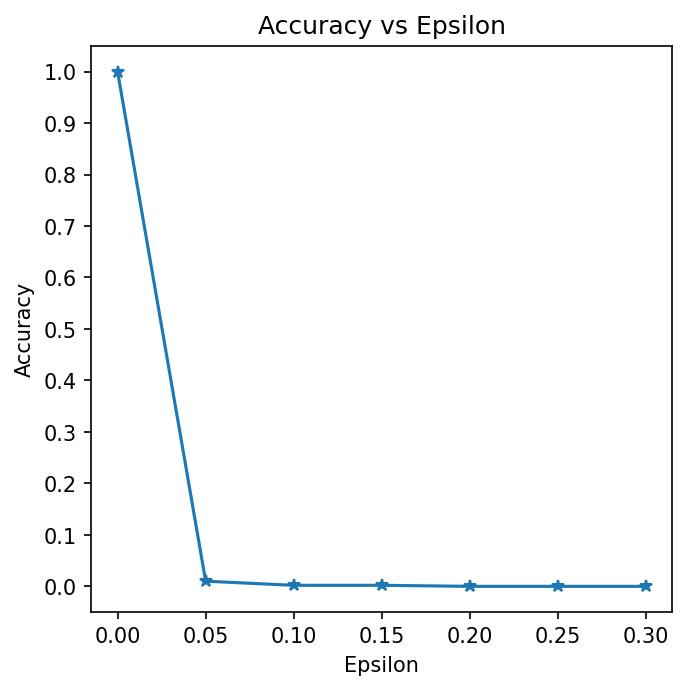

In [43]:
%config InlineBackend.figure_format = 'jpg'  # 强制白底
plt.figure(dpi=150, figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

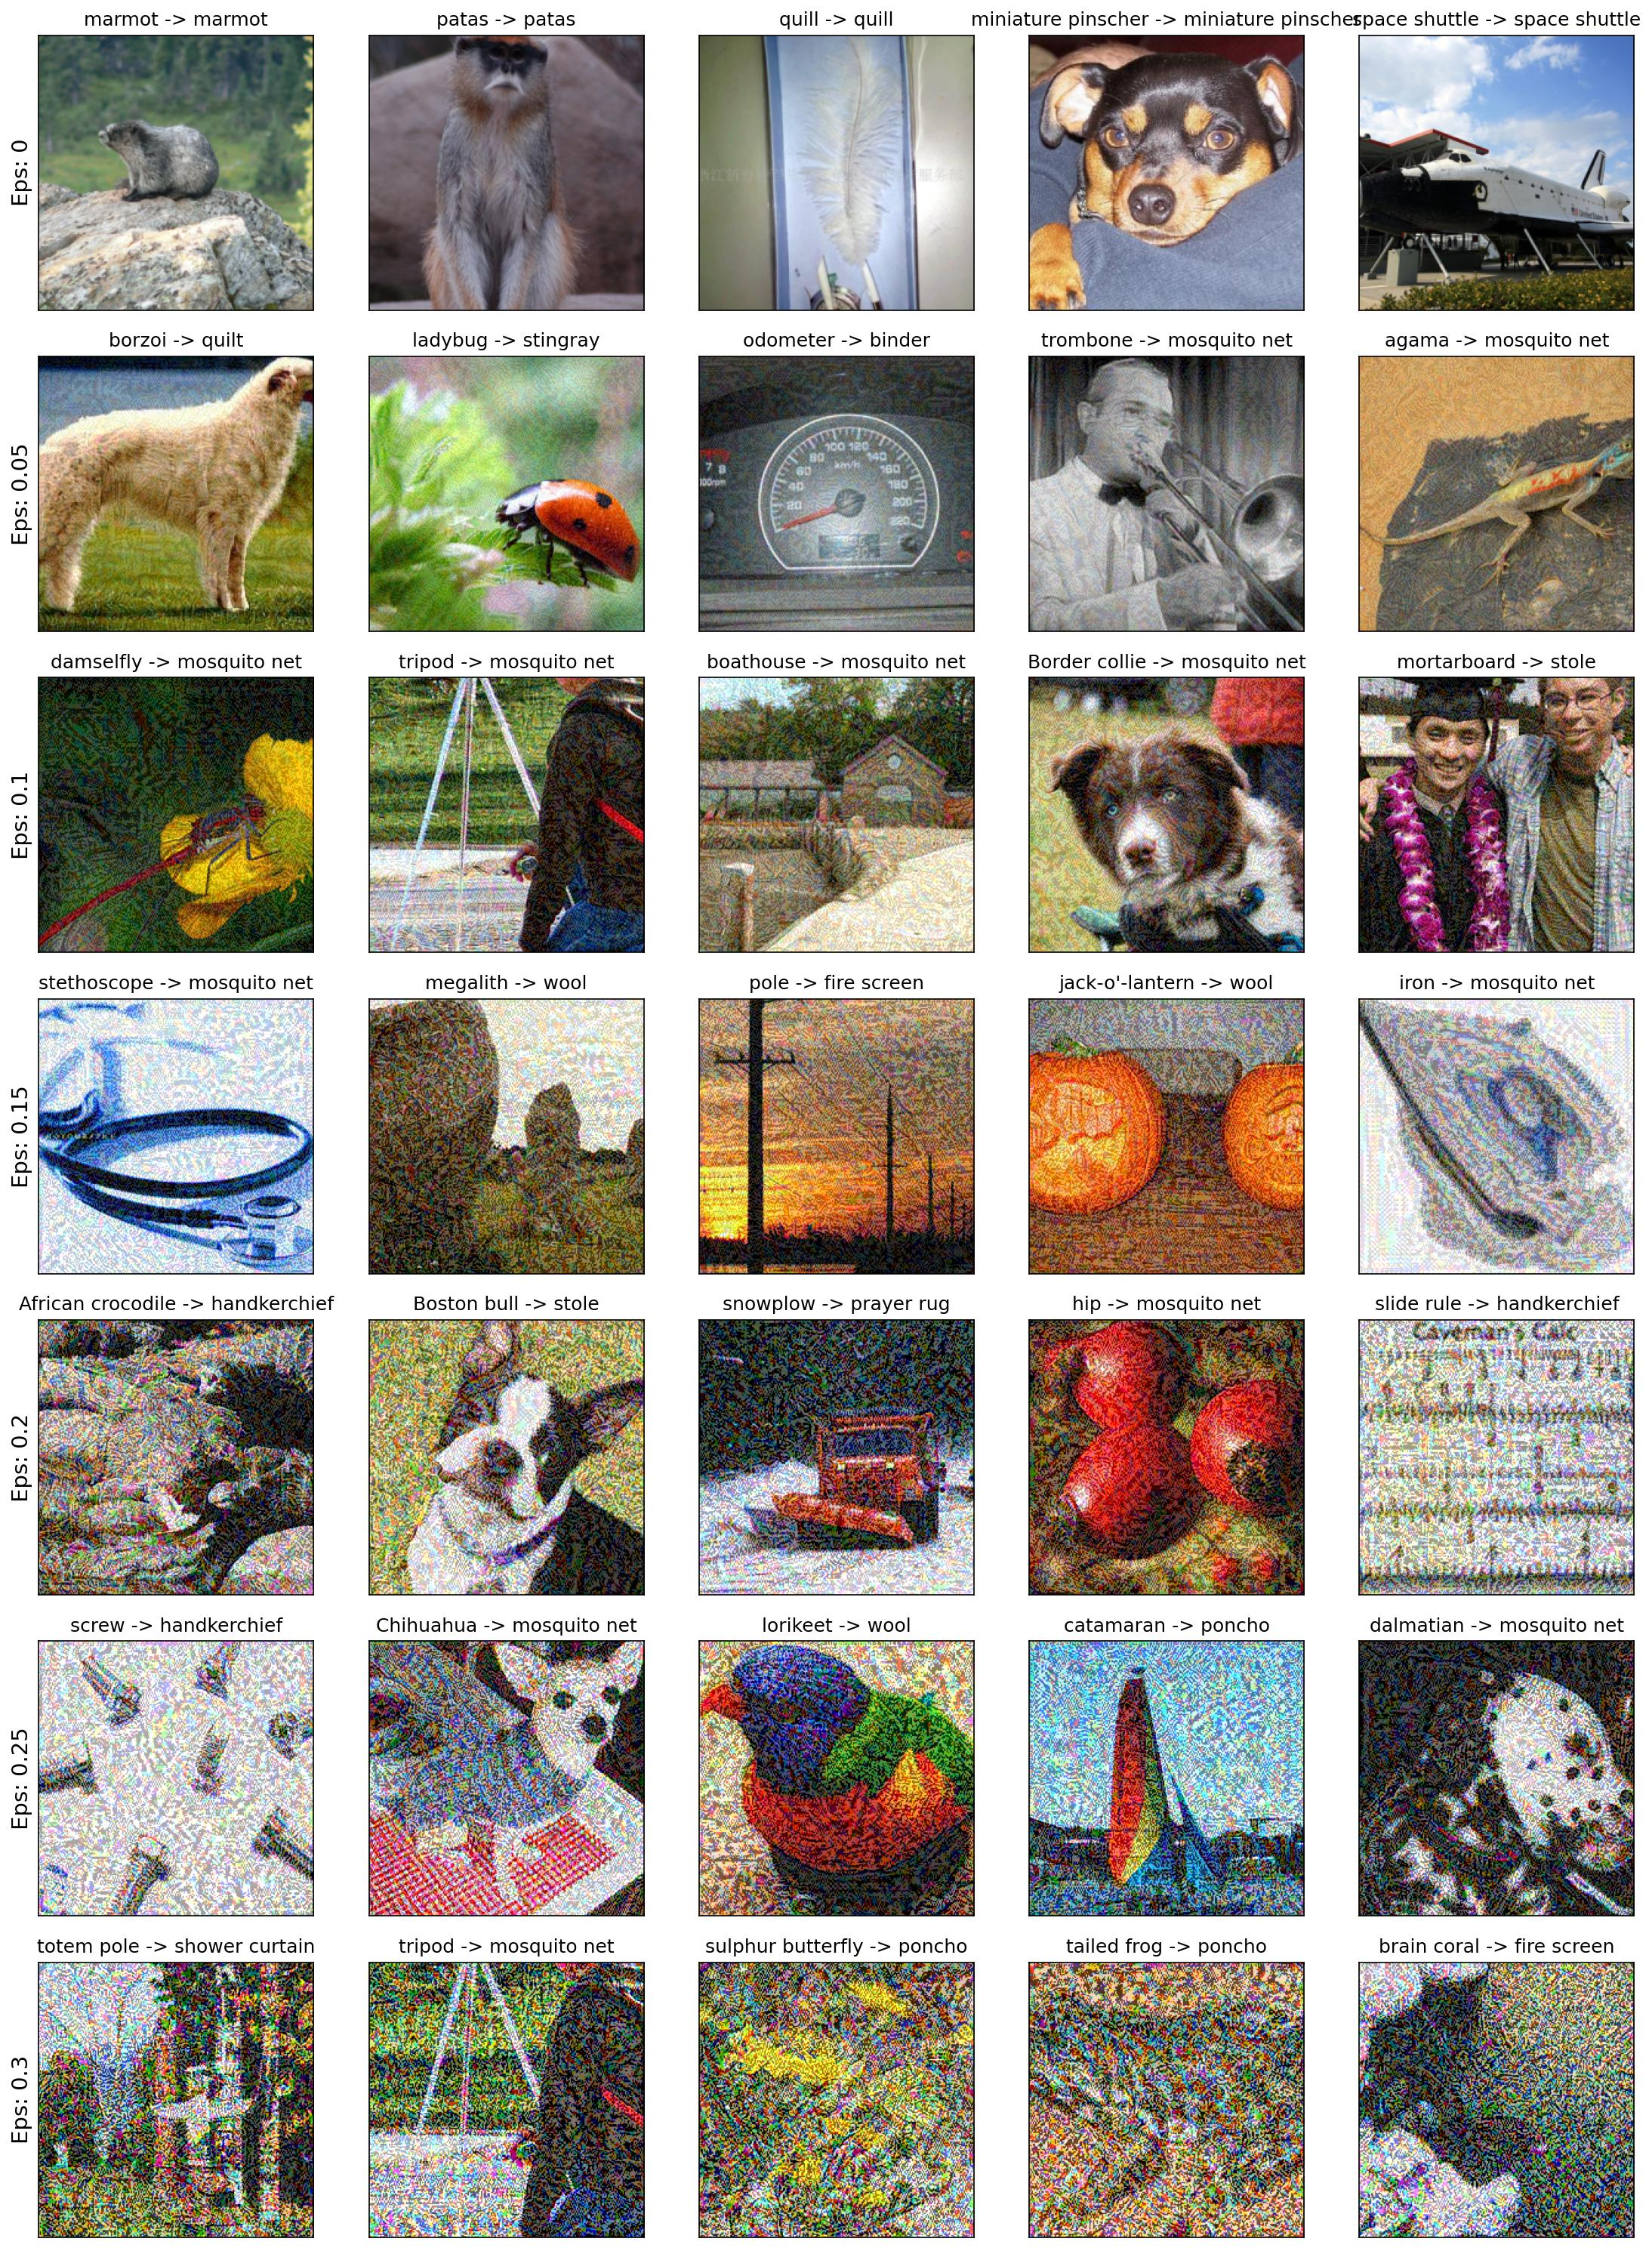

In [44]:
# %config InlineBackend.figure_format = 'jpg'  # 强制白底
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(dpi=150, figsize=(15,20))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        if dataset == 'ImageNet':
            # 从label数值转到class name
            with open("imagenet_classes.txt", "r") as f:
                categories = [s.strip() for s in f.readlines()]
            orig = categories[orig]
            adv = categories[adv]
            # 针对plt显示tensor做一些处理 ref:https://zhuanlan.zhihu.com/p/424638008
            ex = ex.swapaxes(0, 1)
            ex = ex.swapaxes(1, 2)
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
        # plt.imshow(ex)
plt.tight_layout()
plt.show()